In [1]:
import math

In [3]:
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np

In [4]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

from data import load_train_data, load_test_data

Using TensorFlow backend.


In [5]:
img_rows = 96
img_cols = 96

smooth = 1.

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [7]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [8]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [9]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [10]:
print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)
imgs_train, imgs_mask_train = load_train_data()

------------------------------
Loading and preprocessing train data...
------------------------------


In [11]:
imgs_train = preprocess(imgs_train)
imgs_mask_train = preprocess(imgs_mask_train)

/notebooks/lib/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [12]:
imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

In [13]:
imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255.  # scale masks to [0, 1]

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model = get_unet()
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

------------------------------
Creating and compiling model...
------------------------------


In [ ]:
print('-'*30)
print('Fitting model...')
print('-'*30)
model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=20, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint])

------------------------------
Fitting model...
------------------------------


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 4508 samples, validate on 1127 samples
Epoch 1/20
  96/4508 [..............................] - ETA: 3:14:38 - loss: -0.0231 - dice_coef: 0.0231

In [ ]:
print('-'*30)
print('Loading and preprocessing test data...')
print('-'*30)
imgs_test, imgs_id_test = load_test_data()
imgs_test = preprocess(imgs_test)

imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std

In [ ]:
print('-'*30)
print('Loading saved weights...')
print('-'*30)
model.load_weights('weights.h5')

In [ ]:
print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
imgs_mask_test = model.predict(imgs_test, verbose=1)
np.save(os.environ['DATA_DIR']+os.sep+'imgs_mask_test.npy', imgs_mask_test)

In [ ]:
print('-' * 30)
print('Saving predicted masks to files...')
print('-' * 30)
pred_dir = os.environ['TRAINING_DIR']
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for image, image_id in zip(imgs_mask_test, imgs_id_test):
    image = (image[:, :, 0] * 255.).astype(np.uint8)
    imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)

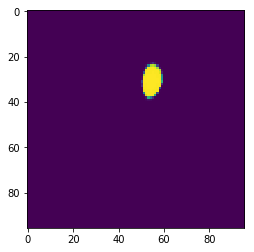

In [13]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import os

%matplotlib inline
pil_im = Image.open(os.environ['TRAINING_DIR']+os.sep+'1000_pred.png', 'r')
imshow(np.asarray(pil_im))

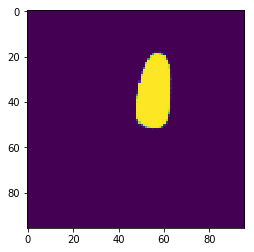

In [14]:
pil_im = Image.open(os.environ['TRAINING_DIR']+os.sep+'1001_pred.png', 'r')
imshow(np.asarray(pil_im))

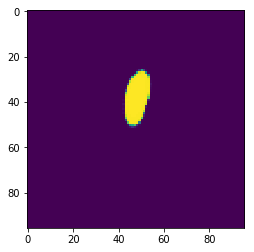

In [15]:
pil_im = Image.open(os.environ['TRAINING_DIR']+os.sep+'1002_pred.png', 'r')
imshow(np.asarray(pil_im))